## Get data from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [4]:
!kaggle datasets download -d rjmanoj/credit-card-customer-churn-prediction

  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 68.8MB/s]


In [167]:
import zipfile

# Define the path to your zip file
# file_path = '/content/drive/MyDrive/kaggle/your_file.zip'  # Replace 'your_file.zip' with your file's name
file_path = '/content/credit-card-customer-churn-prediction.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # zip_ref.extractall('/content/drive/MyDrive/kaggle')  # Replace 'destination_folder' with your desired folder
    zip_ref.extractall('/content/')  # Replace 'destination_folder' with your desired folder

## Project

In [168]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from keras.models import model_from_json

from sklearn.metrics import accuracy_score

In [8]:
df = pd.read_csv("/content/Churn_Modelling.csv")

In [9]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
df.shape

(10000, 14)

In [10]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [12]:
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)

In [13]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [53]:
df.shape

(10000, 11)

In [42]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [74]:
numerical_cols = df.select_dtypes(include=np.number).columns.to_list()
numerical_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [67]:
categorical_cols = list(set(df.columns) - set(numerical_cols))
categorical_cols

['Geography', 'Gender']

In [75]:
for col in categorical_cols:
  print(df[col].value_counts())
  print()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Male      5457
Female    4543
Name: Gender, dtype: int64



In [76]:
for col in numerical_cols:
  print(col, "=>", len(df[col].unique()))

CreditScore => 460
Age => 70
Tenure => 11
Balance => 6382
NumOfProducts => 4
HasCrCard => 2
IsActiveMember => 2
EstimatedSalary => 9999
Exited => 2


In [77]:
categorical_encoded_cols = []

for col in numerical_cols:
  if(len(df[col].unique()) <= 11):
    categorical_encoded_cols.append(col)

categorical_encoded_cols

['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

In [78]:
for col in categorical_encoded_cols:
  print(df[col].value_counts())
  print()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

1    7055
0    2945
Name: HasCrCard, dtype: int64

1    5151
0    4849
Name: IsActiveMember, dtype: int64

0    7963
1    2037
Name: Exited, dtype: int64



In [79]:
numerical_cols = list(set(numerical_cols) - set(categorical_encoded_cols))
numerical_cols

['EstimatedSalary', 'Balance', 'Age', 'CreditScore']

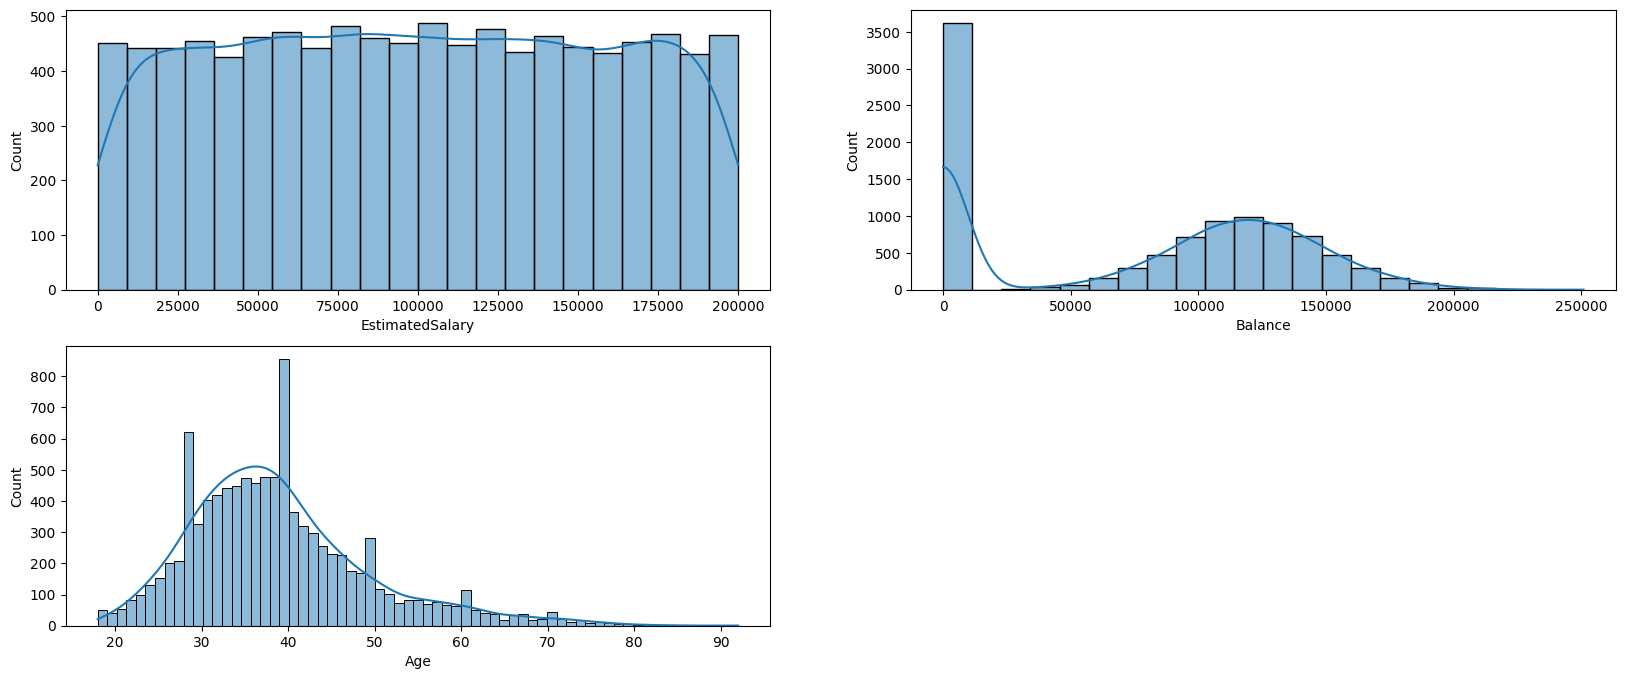

In [80]:
plt.figure(figsize=(20,8))

for i, col in enumerate(numerical_cols[:-1]):
  plt.subplot(2,2,i+1)
  sns.histplot(df[col],
               kde=True)

plt.show()

In [84]:
categorical_cols

['Geography', 'Gender']

In [97]:
transformer = ColumnTransformer(
    transformers=[
        ('tnf1_OneHotEncoder', OneHotEncoder(sparse=False, drop='first'), categorical_cols),
        ('tnf2_Scaling', MinMaxScaler(), numerical_cols)
        ],
    remainder='passthrough')

In [91]:
X = df.drop(columns="Exited")
y = df["Exited"]

In [93]:
print(X.shape)
X.head()

(10000, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [94]:
print(y.shape)
y.head()

(10000,)


0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

In [99]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [109]:
transformer.named_transformers_['tnf1_OneHotEncoder'].categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [110]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7496,824,Germany,Male,49,8,133231.48,1,1,1,67885.37
7694,676,Spain,Female,64,4,116954.32,1,1,1,91149.48
9248,629,Spain,Male,34,6,0.00,2,1,0,190347.72
2470,689,Spain,Female,31,3,139799.63,1,0,1,120663.57
4392,787,France,Male,51,0,58137.08,1,0,1,142538.31


In [111]:
X_train_transformed[:5]

array([[1.        , 0.        , 1.        , 0.33940136, 0.55888604,
        0.41891892, 0.948     , 8.        , 1.        , 1.        ,
        1.        ],
       [0.        , 1.        , 0.        , 0.45573302, 0.4906058 ,
        0.62162162, 0.652     , 4.        , 1.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , 0.95177159, 0.        ,
        0.21621622, 0.558     , 6.        , 2.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.60331757, 0.58643845,
        0.17567568, 0.678     , 3.        , 1.        , 0.        ,
        1.        ],
       [0.        , 0.        , 1.        , 0.71270171, 0.24387632,
        0.44594595, 0.874     , 0.        , 1.        , 0.        ,
        1.        ]])

In [118]:
X_train_transformed.shape

(8000, 11)

input nodes = 11

output nodes = 1

In [119]:
model = Sequential()

# hidden layer 1
model.add(Dense(11, activation='sigmoid',input_dim=11))
# hidden layer 2
model.add(Dense(11, activation='sigmoid'))
# output layer
model.add(Dense(1, activation='sigmoid'))

In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dense_2 (Dense)             (None, 1)                 12        
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 276 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
input_layer_nodes = 11
hidden_layer_1_nodes = 11
hidden_layer_2_nodes = 11
output_layer_nodes = 1

hidden_layer_1_wb = (input_layer_nodes*hidden_layer_1_nodes) + hidden_layer_1_nodes
hidden_layer_2_wb = (hidden_layer_1_nodes*hidden_layer_2_nodes) + hidden_layer_2_nodes
output_layer_wb = (hidden_layer_2_nodes*output_layer_nodes) + output_layer_nodes
total_trainable_params = hidden_layer_1_wb + hidden_layer_2_wb + output_layer_wb

print(hidden_layer_1_wb)
print(hidden_layer_2_wb)
print(output_layer_wb)
print(total_trainable_params)

132
132
12
276


In [123]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [137]:
history = model.fit(X_train_transformed, y_train, batch_size=50, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
128/128 [==============================] - 2s 14ms/step - loss: 0.3904 - accuracy: 0.8331 - val_loss: 0.3888 - val_accuracy: 0.8275
Epoch 2/50
128/128 [==============================] - 0s 3ms/step - loss: 0.3903 - accuracy: 0.8325 - val_loss: 0.3857 - val_accuracy: 0.8325
Epoch 3/50
128/128 [==============================] - 0s 3ms/step - loss: 0.3897 - accuracy: 0.8334 - val_loss: 0.3853 - val_accuracy: 0.8369
Epoch 4/50
128/128 [==============================] - 0s 3ms/step - loss: 0.3892 - accuracy: 0.8330 - val_loss: 0.3869 - val_accuracy: 0.8319
Epoch 5/50
128/128 [==============================] - 0s 3ms/step - loss: 0.3895 - accuracy: 0.8338 - val_loss: 0.3902 - val_accuracy: 0.8275
Epoch 6/50
128/128 [==============================] - 0s 3ms/step - loss: 0.3884 - accuracy: 0.8364 - val_loss: 0.3857 - val_accuracy: 0.8300
Epoch 7/50
128/128 [==============================] - 0s 3ms/step - loss: 0.3879 - accuracy: 0.8356 - val_loss: 0.3838 - val_accuracy: 0.8319
Epoch



```
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

```



In [ ]:
# evaluate the model
scores = model.evaluate(X_test_transformed, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

63/63 [==============================] - 0s 2ms/step - loss: 0.4043 - accuracy: 0.8270

accuracy: 82.70%


In [138]:
y_pred = model.predict(X_test_transformed)
y_pred[:10]

63/63 [==============================] - 0s 2ms/step


array([[0.48504207],
       [0.4927688 ],
       [0.6727681 ],
       [0.13768223],
       [0.61801064],
       [0.50198674],
       [0.16052717],
       [0.2478506 ],
       [0.02799536],
       [0.73698926]], dtype=float32)

In [139]:
y_pred_class = []

for val in y_pred:
  if (val >= 0.5):
    y_pred_class.append(1)
  else:
    y_pred_class.append(0)

y_pred_class[:10]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 1]

In [140]:
accuracy_score(y_test, y_pred_class)

0.827

In [151]:
print(history.history)

{'loss': [0.3903580904006958, 0.3902827501296997, 0.38970711827278137, 0.38921764492988586, 0.3894955813884735, 0.3884294927120209, 0.38792914152145386, 0.3874146342277527, 0.38735291361808777, 0.3873569369316101, 0.3859555423259735, 0.3858141303062439, 0.3849166929721832, 0.3848269283771515, 0.38460591435432434, 0.3839065134525299, 0.3836137056350708, 0.38339319825172424, 0.38267913460731506, 0.3832802176475525, 0.381713330745697, 0.38207411766052246, 0.38140755891799927, 0.38120579719543457, 0.38038650155067444, 0.3799361288547516, 0.37963005900382996, 0.3800240755081177, 0.37905287742614746, 0.3783095180988312, 0.37794455885887146, 0.37730392813682556, 0.3771834671497345, 0.3777473568916321, 0.37683188915252686, 0.37614068388938904, 0.3761783242225647, 0.3757542073726654, 0.37542715668678284, 0.3752064108848572, 0.37481552362442017, 0.3742503225803375, 0.3742160499095917, 0.3736419975757599, 0.3730330169200897, 0.37408292293548584, 0.372633695602417, 0.37245914340019226, 0.372052788

In [153]:
history_keys = list(history.history.keys())
history_keys

['loss', 'accuracy', 'val_loss', 'val_accuracy']

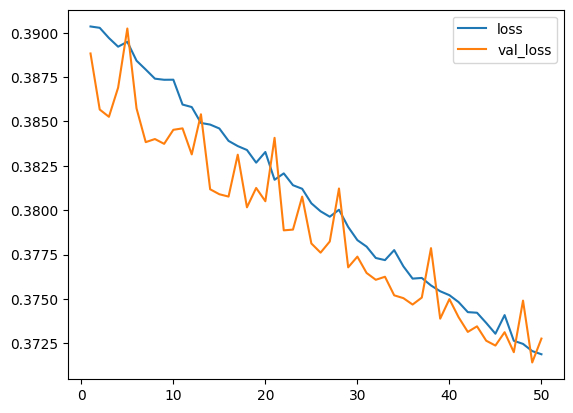

In [160]:
for key in ['loss', 'val_loss']:
  sns.lineplot(x=range(1, 51), y=history.history[key], label=key)

plt.legend()
plt.show()

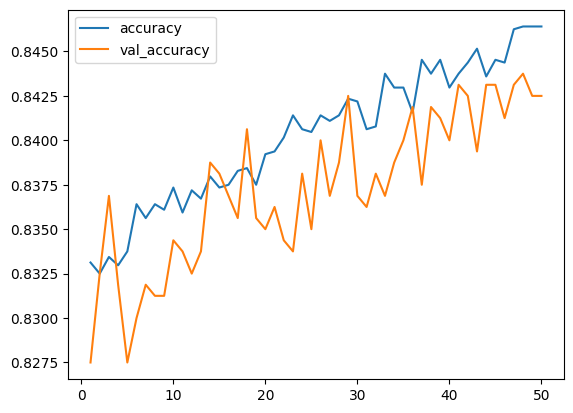

In [161]:
for key in ['accuracy', 'val_accuracy']:
  sns.lineplot(x=range(1, 51), y=history.history[key], label=key)

plt.legend()
plt.show()

Export model

In [163]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Export the weights and bias

In [165]:
# serialize weights to HDF5
model.save_weights("model_params.h5")

In [169]:
# load json and create model
with open('model.json', 'r') as json_file:
  loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

In [171]:
# load weights into new model
model.load_weights("model_params.h5")

In [173]:
y_pred = model.predict(X_test_transformed)
y_pred[:10]

63/63 [==============================] - 0s 2ms/step


array([[0.48504207],
       [0.4927688 ],
       [0.6727681 ],
       [0.13768223],
       [0.61801064],
       [0.50198674],
       [0.16052717],
       [0.2478506 ],
       [0.02799536],
       [0.73698926]], dtype=float32)

In [174]:
y_pred_class = []

for val in y_pred:
  if (val >= 0.5):
    y_pred_class.append(1)
  else:
    y_pred_class.append(0)

y_pred_class[:10]

[0, 0, 1, 0, 1, 1, 0, 0, 0, 1]

In [175]:
accuracy_score(y_test, y_pred_class)

0.827